In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import sys 
import os

root_path = 'C://Users//HP//projects//DiplomaThesis'
sys.path.append(f'{root_path}')

from plots import LatexFigure, corrplot
from data import Meta, Selected

%load_ext autoreload 
%autoreload 2
%matplotlib inline

nn_names_dict = {
    "-1":"LR",
    "32":"NN1",
    "32,16":"NN2",
    "32,16,8":"NN3",
    "32,16,8,4":"NN4",
    "32,16,8,4,2":"NN5"
}

def df_heatmap(df, scale=2, vmin=0, vmax=None, cmap=plt.cm.Blues, flip_cbar=False, show_cbar=True):
    %matplotlib inline
    fig, axis = plt.subplots() # il me semble que c'est une bonne habitude de faire supbplots
    heatmap = axis.pcolor(df, cmap=cmap, vmin=vmin, vmax=vmax)
    labels = [meta.sc_to_latex.get(label) for label in df.index.values.tolist()]
    plt.yticks(np.arange(0.5, len(df.index), 1), labels)
    plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
    axis.invert_yaxis()
    axis.xaxis.tick_top()
    if show_cbar:
        cbar = plt.colorbar(heatmap)
        if flip_cbar:
            cbar.ax.invert_yaxis() 
    fig = LatexFigure(plt.gcf())
    fig.fit(scale=scale)

def subset_models(ar, df, hidden_layers=None, ytrain=None):
    if hidden_layers and not ytrain: 
        sub = (ar["hidden_layers"]==hidden_layers) 
    elif ytrain and not hidden_layers: 
        sub = (ar["ytrain"]==ytrain)
    elif ytrain and hidden_layers: 
        sub = (ar["hidden_layers"]==hidden_layers) & (ar["ytrain"]==ytrain)
    else: 
        sub = df.columns
    return df[sub]

def get_corr_of_seeds(ar, df):
    corr = dict()
    for ytrain in [12,13,14,15,16]:
        corr["{}".format(ytrain)] = dict()
        for hidden_layers in ["32","32,16","32,16,8","32,16,8,4","32,16,8,4,2"]:
            sub = (ar["hidden_layers"]==hidden_layers) & (ar["ytrain"]==ytrain)
            corr["{}".format(ytrain)]["{}".format(hidden_layers)] = df[sub].transpose().corr().dropna(how="all").dropna(how="all", axis=1).values.mean()
    return corr

def load_dataframes(fpath):
    ar = pd.read_csv(os.path.join(fpath, "args.csv"), index_col=0)
    pe = pd.read_csv(os.path.join(fpath, "performance.csv"), index_col=0)
    ig = pd.read_csv(os.path.join(fpath, "integrated_gradients_global.csv"), index_col=0)
    mr = pd.read_csv(os.path.join(fpath, "model_reliance.csv"), index_col=0)
    return ar, pe, ig, mr

def name(ar, df, variables):
    old_names = df.columns.tolist()
    lists = [ar.loc[old_names][var].values.astype(str).tolist() for var in variables]
    df.columns = ["-".join(l) for l in list(zip(*lists))]
    df = df.reindex(sorted(df.columns), axis=1)
    return df

def get_orders(row):
    array = row.values
    temp = sorted(list(array))
    res = np.array([temp.index(i) for i in array])
    return pd.Series(res, row.index)

def get_parts(row, nparts):
    array = row.values
    temp = sorted(list(array))
    res = np.array([temp.index(i) for i in array])
    labels = list(reversed((np.arange(nparts)+1)*(30/nparts)))
    return pd.qcut(pd.Series(res, row.index).rank(method='first'),nparts,labels).astype(float)

In [2]:
meta = Meta()
meta.load()

dataset = Selected()
dataset.load()

# Ensembles

In [42]:
fpath = os.path.join("results", "ensembles")
ar, pe, ig, mr = load_dataframes(fpath)
SORTING = subset_models(ar, ig, hidden_layers=None, ytrain=16).mean().abs().sort_values(ascending=False).index.tolist()
SORTING_LATEX = [meta.sc_to_latex.get(k) for k in SORTING]
ig = ig[SORTING]
mr = mr[SORTING]
ar["nn_name"] = ar[["hidden_layers"]].replace(nn_names_dict)
ar["nn_name_short"] = [s[-1:] for s in ar.nn_name]

### Integrated gradients show size of impact of features on the prediction values

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


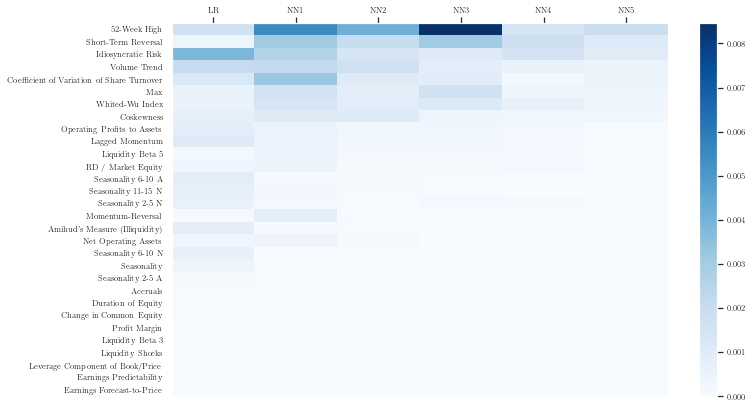

In [43]:
df_heatmap(
    name(
        ar, 
        subset_models(
            ar, ig, hidden_layers=None, ytrain=16
        ).transpose(),
        ["nn_name"]
    ),
    cmap=plt.cm.Blues,
    vmin=0,
    show_cbar=True
)

### Model Reliance shows how distorting a features harms the model's performance

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


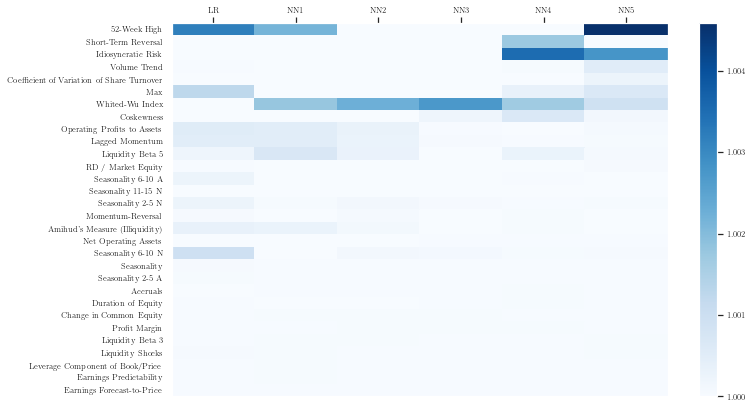

In [5]:
df_heatmap(
    name(
        ar, 
        subset_models(
            ar, mr, hidden_layers=None, ytrain=16
        ).transpose(),
        ["nn_name"]
    ),
    cmap=plt.cm.Blues,
    vmin=1,
    show_cbar=True
)

### All ensembles agree on 10 most influential features (IG)

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


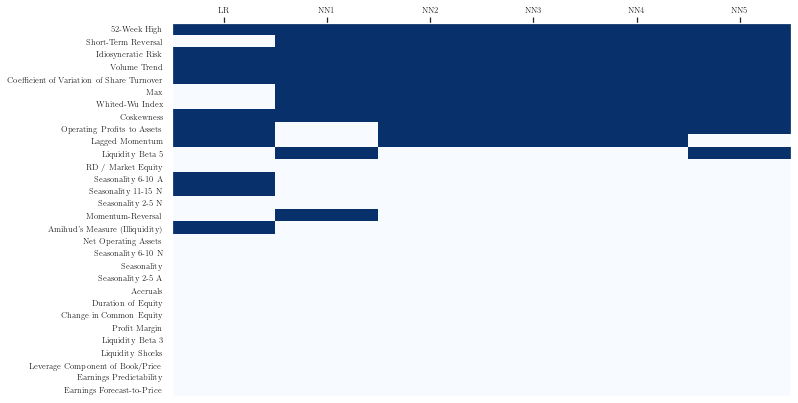

In [6]:
df = (ig.apply(lambda x: get_orders(x), axis=1)>=20)
df_heatmap(
    name(
        ar, 
        subset_models(
            ar, df, hidden_layers=None, ytrain=16
        ).transpose(),
        ["nn_name"]
    ),
    cmap=plt.cm.Blues,
    vmin=0,
    show_cbar=False
)

### All ensembles agree on 10 least influential features (IG)

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


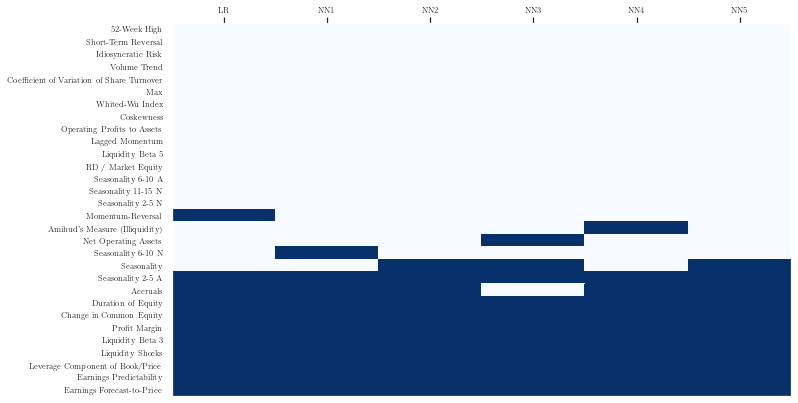

In [7]:
df = (ig.apply(lambda x: get_orders(x), axis=1)<=10)
df_heatmap(
    name(
        ar, 
        subset_models(
            ar, df, hidden_layers=None, ytrain=16
        ).transpose(),
        ["nn_name"]
    ),
    cmap=plt.cm.Blues,
    vmin=0,
    show_cbar=False
)

### All ensembles agree on top and bottom features by influence, but the middle is mixed (IG)

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


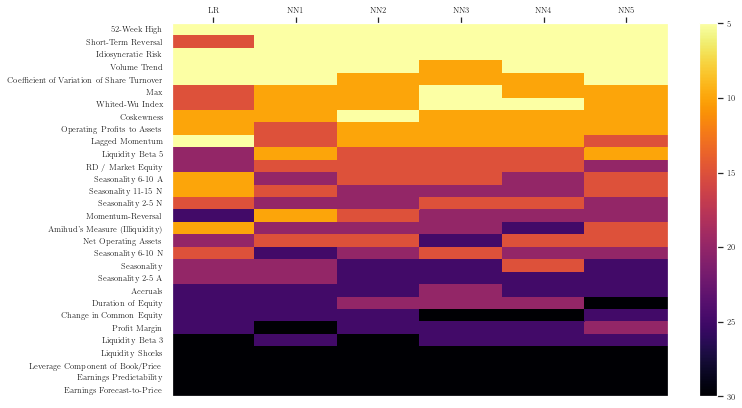

In [8]:
df = ig.apply(lambda x: get_parts(x,6), axis=1)
df_heatmap(
    name(
        ar, 
        subset_models(
            ar, df, hidden_layers=None, ytrain=16
        ).transpose(),
        ["nn_name"]
    ),
    cmap=plt.cm.inferno_r,
    vmin=None,
    flip_cbar=True
)

### While IG are same across models, Model Reliances are different (top 10 features)

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


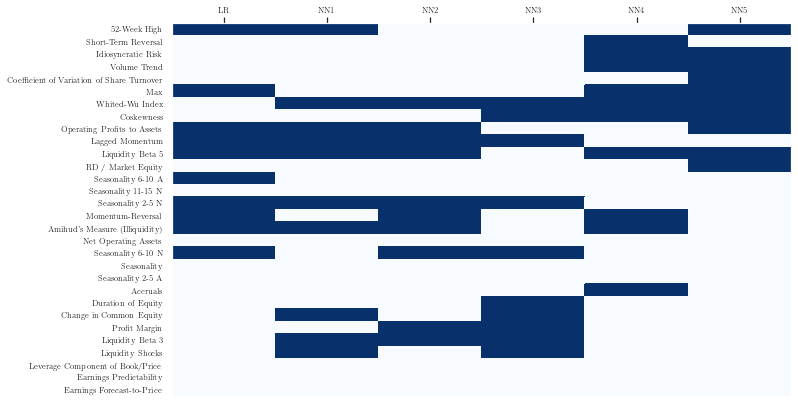

In [9]:
df = (mr.apply(lambda x: get_orders(x), axis=1)>=20)
df_heatmap(
    name(
        ar, 
        subset_models(
            ar, df, hidden_layers=None, ytrain=16
        ).transpose(),
        ["nn_name"]
    ),
    cmap=plt.cm.Blues,
    vmin=0,
    show_cbar=False
)

### While IG are same across models, Model Reliances are different (bottom 10 features)

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


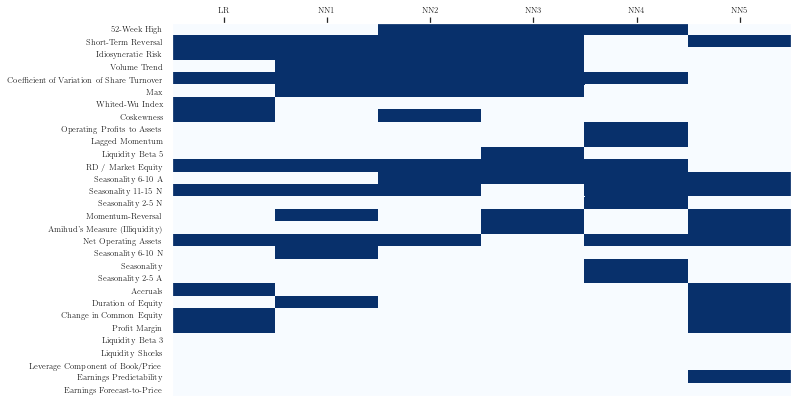

In [10]:
df = (mr.apply(lambda x: get_orders(x), axis=1)<=10)
df_heatmap(
    name(
        ar, 
        subset_models(
            ar, df, hidden_layers=None, ytrain=16
        ).transpose(),
        ["nn_name"]
    ),
    cmap=plt.cm.Blues,
    vmin=0,
    show_cbar=False
)

### Relative importance of features differes across ensembles (MR)

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


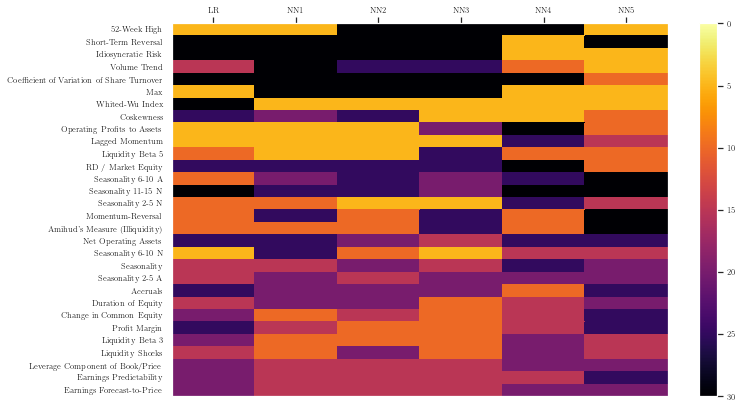

In [11]:
df = mr.apply(lambda x: get_parts(x,6), axis=1)
df_heatmap(
    name(
        ar, 
        subset_models(
            ar, df, hidden_layers=None, ytrain=16
        ).transpose(),
        ["nn_name"]
    ),
    cmap=plt.cm.inferno_r,
    vmin=0,
    flip_cbar=True
)

### Why is MR and IG so different? 
IG is high for features whose **values** have big impact on the **value** of the prediction, if other features are at 0. (It **ignores the correlation** of the features.)

MR is high for features whose **distortion** worsens the **error** of the prediction relative to truth. It **takes into account the correlation** of the features.

The issue is the mirror of that in linear regression, coefficients of a variable (IG) can be big and yet the variable can be insignificant due to multicollinearity and a lot more features present (MR)

### MR and IG agree the more the deeper the model

In [12]:
def compare_mr_ig(hidden_layers):
    df_mr = (mr.apply(lambda x: get_orders(x), axis=1)>=20)
    df_mr = name(
            ar, 
            subset_models(
                ar, df_mr, hidden_layers=hidden_layers, ytrain=16
            ).transpose(),
            ["nn_name"])
    df_ig = (ig.apply(lambda x: get_orders(x), axis=1)>=20)
    df_ig = name(
            ar, 
            subset_models(
                ar, df_ig, hidden_layers=hidden_layers, ytrain=16
            ).transpose(),
            ["nn_name"])
    df = pd.concat([df_ig,df_mr,],axis=1)
    df.columns = ["IG", "MR"]
    return df

In [13]:
overlap_top_10 = dict()
for hl in ["32","32,16","32,16,8", "32,16,8,4", "32,16,8,4,2"]:
    df = compare_mr_ig(hl)
    overlap_top_10[hl] = ((df.IG == True) & (df.MR == True)).sum()
overlap_top_10

{'32': 3, '32,16': 3, '32,16,8': 3, '32,16,8,4': 6, '32,16,8,4,2': 9}

**NN1**

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


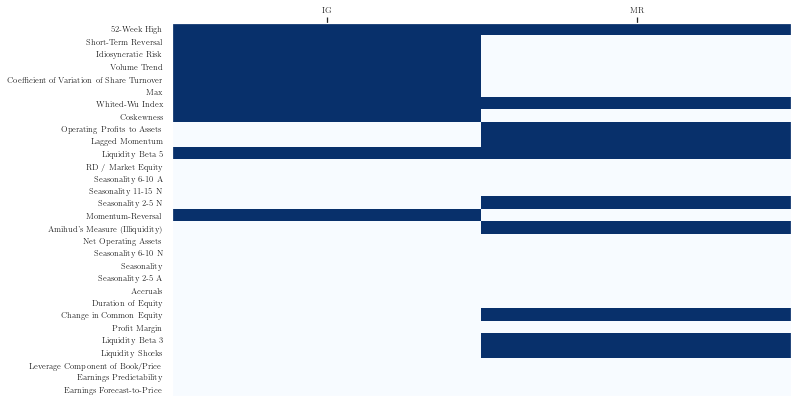

In [14]:
df_heatmap(
    compare_mr_ig("32"),
    cmap=plt.cm.Blues,
    vmin=0,
    show_cbar=False
)

**NN5**

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


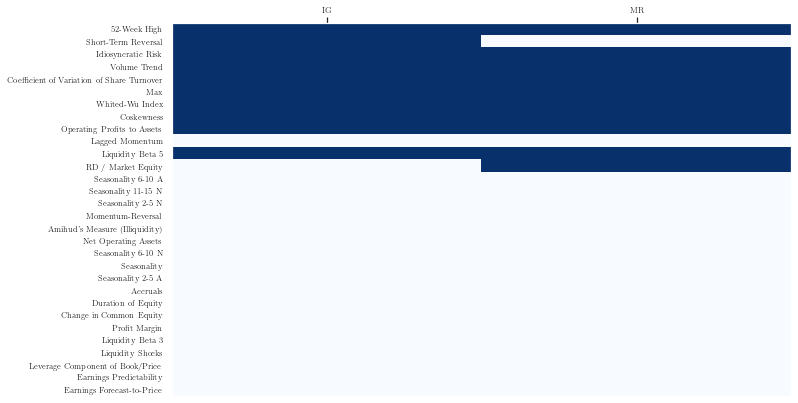

In [15]:
df_heatmap(
    compare_mr_ig("32,16,8,4,2"),
    cmap=plt.cm.Blues,
    vmin=0,
    show_cbar=False
)

# Seeds

In [16]:
fpath = "results/individual"
ar, pe, ig, mr = load_dataframes(fpath)
ig = ig[SORTING]
mr = mr[SORTING]
ar["nn_name"] = ar[["hidden_layers"]].replace(nn_names_dict)
ar["nn_name_short"] = [s[-1:] for s in ar.nn_name]

### Integrated Gradients do not change across seeds (10 most important featues)

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


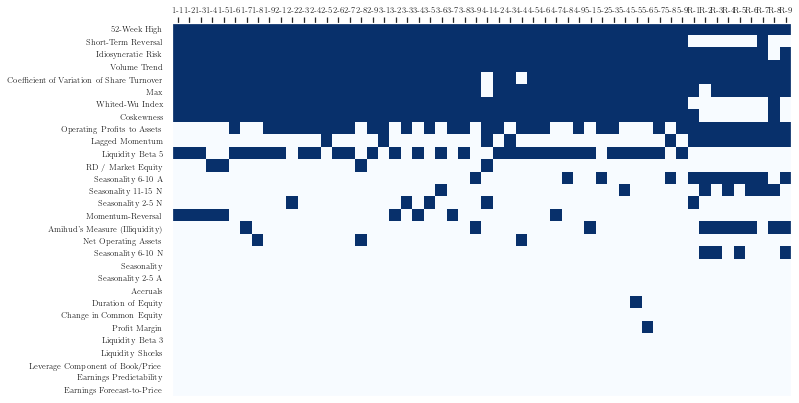

In [21]:
df = (ig.apply(lambda x: get_orders(x), axis=1)>=20)
df_heatmap(
    name(
        ar, 
        subset_models(
            ar, df, hidden_layers=None, ytrain=16
        ).transpose(),
        ["nn_name_short", "seed"]
    ),
    cmap=plt.cm.Blues,
    vmin=0,
    show_cbar=False
)

### Integrated Gradients do not change across seeds (features grouped by importance into categories of 5)

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


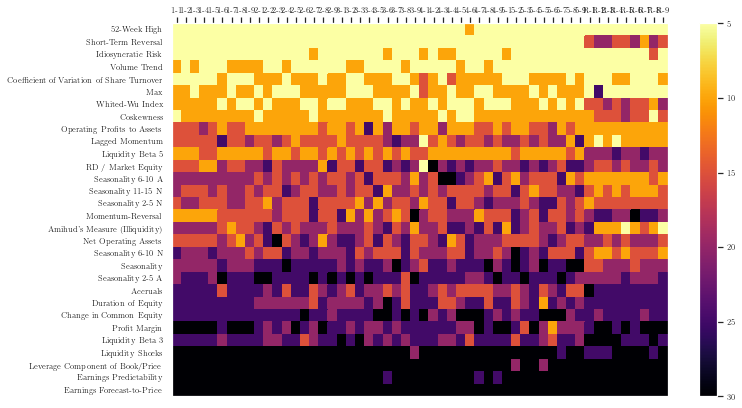

In [22]:
df = (ig.apply(lambda x: get_parts(x,6), axis=1))
df_heatmap(
    name(
        ar, 
        subset_models(
            ar, df, hidden_layers=None, ytrain=16
        ).transpose(),
        ["nn_name_short", "seed"]
    ),
    cmap=plt.cm.inferno_r,
    vmin=None,
    flip_cbar=True
)

### This is especially true for simple models. It is also visible in the figure above. This is the correlation of seeds within each NN (lines represnt multiple train-test splits).

<AxesSubplot:>

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


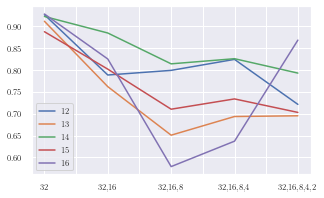

In [23]:
ig_corr = get_corr_of_seeds(ar, ig)
pd.DataFrame(ig_corr).plot()

### Model Reliance changes across seeds considerably (10 most important features)

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


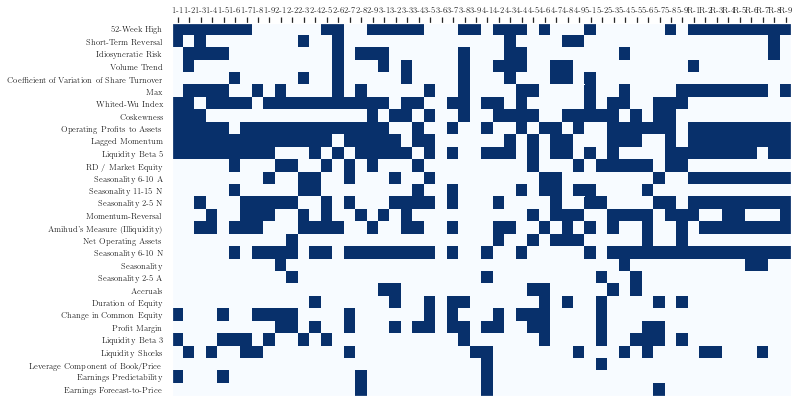

In [24]:
df = (mr.apply(lambda x: get_orders(x), axis=1)>=20)
df_heatmap(
    name(
        ar, 
        subset_models(
            ar, df, hidden_layers=None, ytrain=16
        ).transpose(),
        ["nn_name_short", "seed"]
    ),
    cmap=plt.cm.Blues,
    vmin=0,
    show_cbar=False
)

### Model Reliance changes across seeds considerably (features grouped by importance into categories of 5)

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


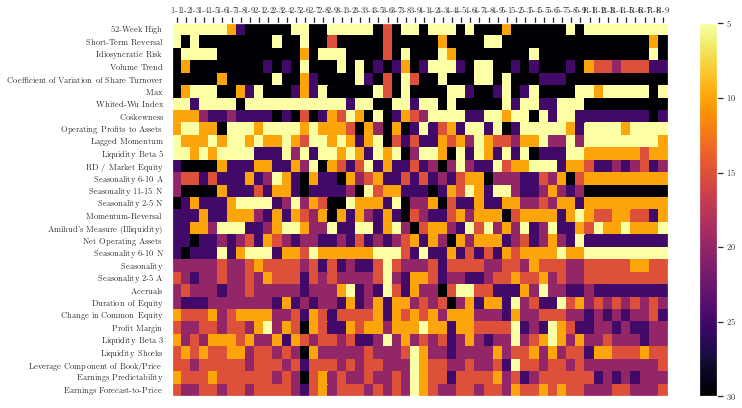

In [25]:
df = (mr.apply(lambda x: get_parts(x,6), axis=1))
df_heatmap(
    name(
        ar, 
        subset_models(
            ar, df, hidden_layers=None, ytrain=16
        ).transpose(),
        ["nn_name_short", "seed"]
    ),
    cmap=plt.cm.inferno_r,
    vmin=None,
    flip_cbar=True
)

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


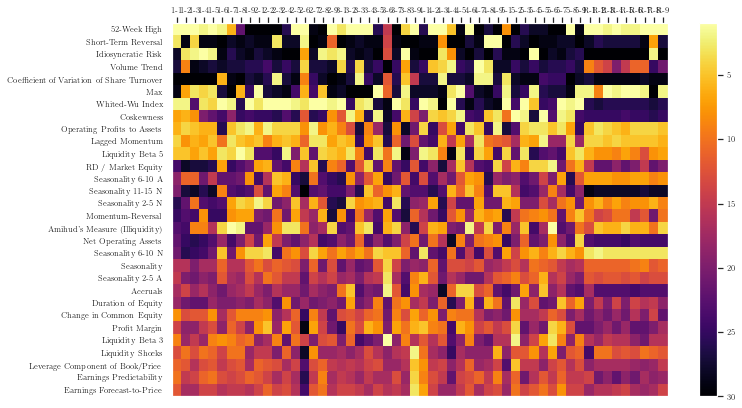

In [26]:
df = (mr.apply(lambda x: get_parts(x,30), axis=1))
df_heatmap(
    name(
        ar, 
        subset_models(
            ar, df, hidden_layers=None, ytrain=16
        ).transpose(),
        ["nn_name_short", "seed"]
    ),
    cmap=plt.cm.inferno_r,
    vmin=None,
    flip_cbar=True
)

### This is true especially for top features (zooming in the previous figure)

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


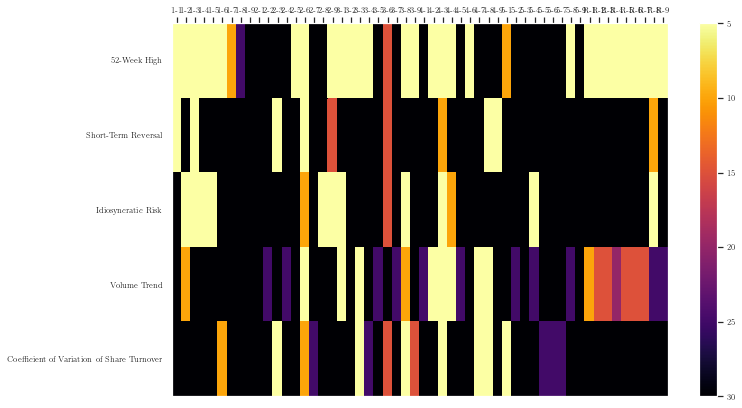

In [27]:
df = (mr.apply(lambda x: get_parts(x,6), axis=1))
df_heatmap(
    name(
        ar, 
        subset_models(
            ar, df, hidden_layers=None, ytrain=16
        ).transpose().head(5),
        ["nn_name_short", "seed"]
    ),
    cmap=plt.cm.inferno_r,
    vmin=None,
    vmax=30,
    flip_cbar=True
)

### Compare to IG

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


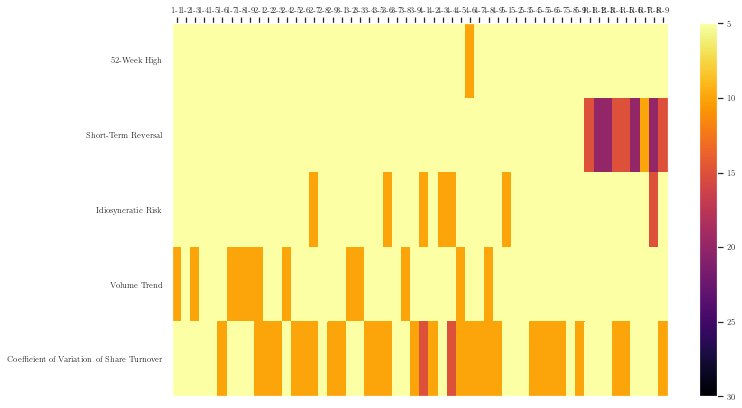

In [28]:
df = (ig.apply(lambda x: get_parts(x,6), axis=1))
df_heatmap(
    name(
        ar, 
        subset_models(
            ar, df, hidden_layers=None, ytrain=16
        ).transpose().head(5),
        ["nn_name_short", "seed"]
    ),
    cmap=plt.cm.inferno_r,
    vmin=None,
    vmax=30,
    flip_cbar=True
)

# Feature correlations

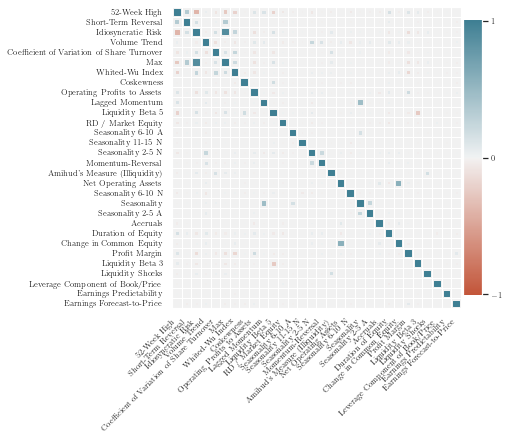

In [29]:
corr = dataset.features[SORTING].corr()
corr.rename(index=meta.sc_to_latex, inplace=True)
corr.columns = corr.index.values

corrplot(corr, size_scale=30, legend=True)
fig = LatexFigure(plt.gcf())
fig.fit(square=True)

### Closer look to top 10 by IG

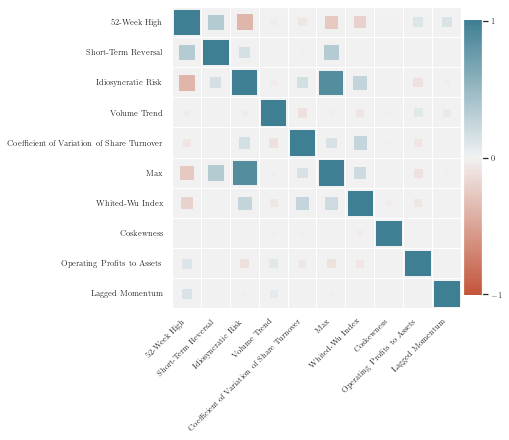

In [30]:
corrplot(corr.iloc[:10,:10], size_scale=600, legend=True)
fig = LatexFigure(plt.gcf())
fig.fit(square=True)

### 10 Most correlated pairs

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


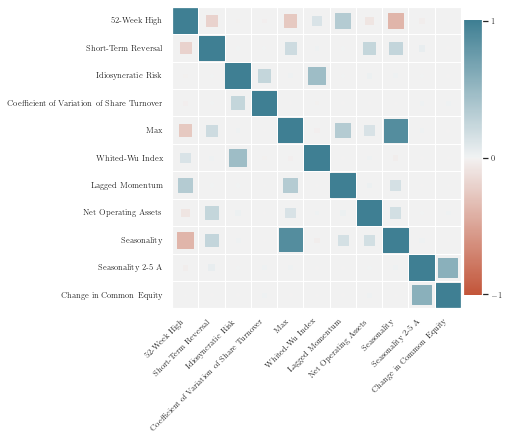

In [31]:
# Get most correlated pairs
so = corr.unstack().abs().sort_values()
hi = so[so!=1].iloc[::2].tail(10).sort_values(ascending=False)
highest = list(set(hi.index.get_level_values(0)).union(set(hi.index.get_level_values(1))))
df = corr.loc[highest,highest]
ordered_index = [s for s in SORTING_LATEX if s in list(df.columns)]
df.columns = ordered_index
df.index = ordered_index
corrplot(df, size_scale=600, legend=True)
fig = LatexFigure(plt.gcf())
fig.fit(square=True)

In [32]:
so = corr.loc[highest,highest].unstack().sort_values()
so[so!=1].iloc[::2].tail(8).sort_values(ascending=False).round(3)

Max                                         Idiosyncratic Risk         0.885
Net Operating Assets                        Change in Common Equity    0.581
Lagged Momentum                             Seasonality                0.474
52-Week High                                Short-Term Reversal        0.348
Short-Term Reversal                         Max                        0.344
Idiosyncratic Risk                          Whited-Wu Index            0.260
Seasonality                                 Seasonality 2-5 A          0.254
Coefficient of Variation of Share Turnover  Whited-Wu Index            0.252
dtype: float64

In [33]:
so[so!=1].iloc[::2].head(2).sort_values(ascending=True).round(3)

52-Week High  Idiosyncratic Risk   -0.385
              Max                  -0.256
dtype: float64

### MR and IG seem to depend on correlation of the feature

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


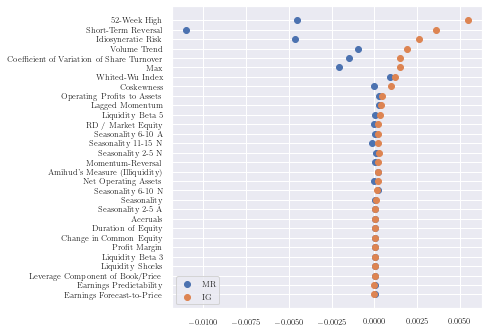

In [34]:
mr16 = subset_models(ar, mr, hidden_layers=None, ytrain=16)-1
ig16 = subset_models(ar, ig, hidden_layers=None, ytrain=16)
means = (pd.DataFrame(mr16.mean(), columns= ["MR"]).rename(index=meta.sc_to_latex))
means["IG"] = ig16.abs().mean().rename(index=meta.sc_to_latex)

fig, axis = plt.subplots(figsize=(8,8))
plt.plot(means, np.arange(len(means)), 'o')
plt.yticks(np.arange(0, len(means.index), 1), means.index.values.tolist())
axis.invert_yaxis()
axis.legend(means.columns.tolist())
fig = LatexFigure(plt.gcf())
fig.fit(square=True)

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


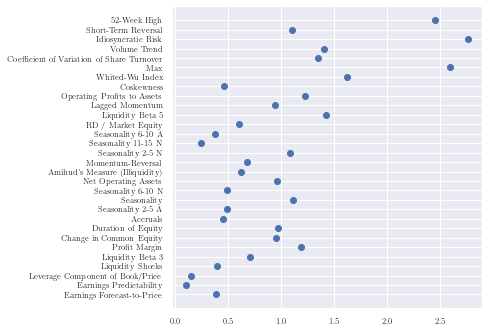

In [35]:
fig, axis = plt.subplots(figsize=(8,8))
plt.plot(corr.abs().sum()-1, np.arange(len(corr)), 'o')
plt.yticks(np.arange(0, len(corr.index), 1), corr.index.values.tolist())
axis.invert_yaxis()
fig = LatexFigure(plt.gcf())
fig.fit(square=True)

## Feature descriptives

In [36]:
df = dataset.features[SORTING].describe().transpose().round(4)
df.rename(index=meta.sc_to_latex, inplace=True)
df = df[df.columns.tolist()[1:]]
#with open('latex/Tables/descr.tex','w') as tf:
#    tf.write(df.to_latex())

In [37]:
df.head()

,mean,std,min,25%,50%,75%,max
52-Week High,-0.0,0.3316,-1.0000,-0.1828,0.0764,0.2445,0.678
Short-Term Reversal,-0.0,0.2430,-0.9831,-0.1276,-0.0178,0.1027,1.000
Idiosyncratic Risk,-0.0,0.1999,-0.2929,-0.1204,-0.0539,0.0528,1.000
Volume Trend,0.0,0.2040,-0.8532,-0.0873,0.0000,0.0979,1.000
Coefficient of Variation of Share Turnover,-0.0,0.1144,-0.1469,-0.0625,-0.0279,0.0170,1.000


In [38]:
df = meta.signals[~meta.signals.important_otmh_global_liquid.isna()]
df = df[["name_tex", "tex_cite", "class", "class2", "freq", "kelly_sc", "journal"]]
df.set_index('name_tex', inplace=True)
df = df.loc[SORTING_LATEX]

In [39]:
df.head()

,tex_cite,class,class2,freq,kelly_sc,journal
name_tex,,,,,,
52-Week High,george200452,frictions,other,monthly,NaN,JF
Short-Term Reversal,jegadeesh1990evidence,frictions,other,monthly,mom1m,JF
Idiosyncratic Risk,ang2006cross,frictions,other,monthly,idiovol,JF
Volume Trend,haugen1996commonality,frictions,other,monthly,NaN,JFE
Coefficient of Variation of Share Turnover,chordia2001trading,frictions,other,monthly,std_turn,JFE


In [40]:
df.to_latex()

"\\begin{tabular}{lllllll}\n\\toprule\n{} &                    tex\\_cite &      class &         class2 &         freq &  kelly\\_sc & journal \\\\\nname\\_tex                                   &                             &            &                &              &           &         \\\\\n\\midrule\n52-Week High                               &                george200452 &  frictions &          other &      monthly &       NaN &      JF \\\\\nShort-Term Reversal                        &       jegadeesh1990evidence &  frictions &          other &      monthly &    mom1m  &      JF \\\\\nIdiosyncratic Risk                         &                ang2006cross &  frictions &          other &      monthly &   idiovol &      JF \\\\\nVolume Trend                               &       haugen1996commonality &  frictions &          other &      monthly &       NaN &     JFE \\\\\nCoefficient of Variation of Share Turnover &          chordia2001trading &  frictions &          other &    

### Plot of returns

In [ ]:
# zscore more than 8 is considered outlier
r_without_outliers = dt.targets.r[np.abs((dt.targets['r'] - dt.targets['r'].mean())/dt.targets['r'].std(ddof=0)<8)]

from scipy import stats
r_without_outliers.plot.hist(grid=True, bins=100, rwidth=0.9)
plt.xlabel('Monthly Return')
plt.ylabel('Number of Observations')
fig = Figure(plt.gcf())
fig.fit()